In [57]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random

#랜덤 시드 고정
SEED=12
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

#구글 드라이브 폴더 마운트
from google.colab import drive, files
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [58]:
drive_path = "/gdrive/My Drive/"
train = pd.read_csv(drive_path + "mnist_data/train.csv")
test = pd.read_csv(drive_path + "mnist_data/test.csv")
submission = pd.read_csv(drive_path + "mnist_data/sample_submission.csv")

print(train.shape, test.shape, submission.shape)

(60000, 786) (10000, 785) (10000, 2)


In [59]:
#train 데이터 보자
train.head()

#확인해보니
#고유 아이디를 나타내는 index열, 정답 레이블인 label열 이후로는 pixel열 784개


,index,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,9,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,6,0,0,0,0,0,0,0,5,...,0,0,0,30,43,0,0,0,0,0
3,3,0,0,0,0,1,2,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,4,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
#784개의 픽셀이 1차원 벡터 형태로 펼쳐진 상태
#실제 이미지 형태로 보기 위해서는 가로 28픽셀 세로 28픽셀 형태로 변환하는 과정이 필요하다. (28*28 = 784)

#train 데이터를 28*28 이미지로 변환
train_images = train.loc[:,'pixel1':].values.reshape(-1,28,28)
train_images.shape

#6만개의 이미지

(60000, 28, 28)

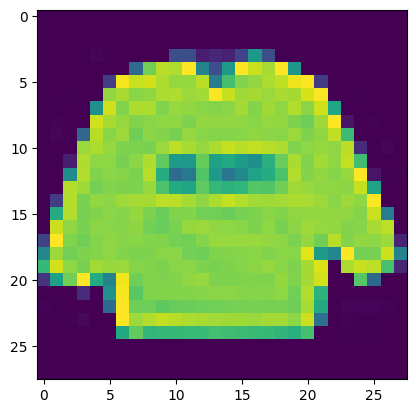

In [61]:
#첫 번째 이미지 출력
import matplotlib.pyplot as plt
plt.imshow(train_images[0]);

In [62]:
#목표 레이블
y_train = train.loc[:,'label']
y_train.unique()  #분류 예측 목표가 되는 레이블 값을 확인하니 0~9 범위의 정수 레이블 형태

array([2, 9, 6, 0, 3, 4, 5, 8, 7, 1])

In [63]:
#문제에 나와있는 실제 레이블을 숫자와 연결하자
target_values = {0:'T-shirt/top',
                 1:'Trouser',
                 2:'Pullover',
                 3:'Dress',
                 4:'Coat',
                 5:'Sandal',
                 6:'Shirt',
                 7:'Sneaker',
                 8:'Bag',
                 9:'Ankle boot'
}
print(y_train[0])
print(target_values[y_train[0]])

2
Pullover


In [64]:
#test 데이터를 28*28 이미지로 변환하자
test_images = test.loc[:,'pixel1':].values.reshape(-1,28,28)
test_images.shape

(10000, 28, 28)

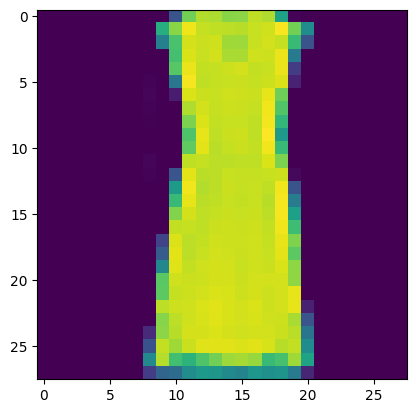

In [65]:
plt.imshow(test_images[499]);

In [66]:
#딥러닝 학습을 위해 정규화 변환하는 과정이 중요!
#이미지 픽셀은 0~255 범위의 값을 가지기에 255로 나누면 0~1 범위로 축소된다.

#피처스케일링
X_train = train_images /255.

X_test = test_images /255.
print("최소값:", X_train[0].min())  #pixel1
print("최대값:", X_test[0].max())

최소값: 0.0
최대값: 1.0


In [67]:
#일반적으로 이미지는 가로 세로 픽셀 크기와 더불어 3채널(Red Blue Green) 색상을 추가하여 나타낸다
#CNN은 RGB 채널 값을 입력받은 것을 전제로 설계되어 있기 때문에 합성곱 신경망(CNN)을 사용하기 위해서는 이미지 차원을 추가해야한다.
#numpy 패키지의 expand_dims 함수를 사용하면 데이터셋 배열에 채널이 추가된다.

#채널 차원 추가
print("변환전: ", X_train.shape, X_test.shape)
X_train = np.expand_dims(X_train, axis= -1)
X_test = np.expand_dims(X_test, axis= -1)
print("변환후: ", X_train.shape, X_test.shape)

변환전:  (60000, 28, 28) (10000, 28, 28)
변환후:  (60000, 28, 28, 1) (10000, 28, 28, 1)


In [68]:
#홀드아웃 교차 검증을 위한 데이터셋 분할
#Train-Validation 데이터 구분
#stratify 옵션을 사용하여 목표 레이블의 분포를 고려
from sklearn.model_selection import train_test_split
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = 0.2,
                                            stratify = y_train,
                                            shuffle=True, random_state=SEED)
print(X_tr.shape, X_val.shape)
print(y_tr.shape, y_val.shape)

(48000, 28, 28, 1) (12000, 28, 28, 1)
(48000,) (12000,)


In [69]:
#MLP 모델 학습
#Flatten레이어를 사용하면 가로 세로 형태의 이미지를 데이콘에서 다운받은 데이터와 같이 1차원 배열로 펼칠 수 있다.
#Dense레이어 2개를 쌓은 신경망
#출력 레이어의 유닛은 10(목표 레이블의 개수)
#활성화 함수는 다중 분류 문제에 맞는 softmax
#따라서 784개의 입력을 받아 10개의 출력으로 변환

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
mlp_model = Sequential()
mlp_model.add(Flatten(input_shape=[28,28]))
mlp_model.add(Dense(units=64,activation = 'relu'))
mlp_model.add(Dense(units=10, activation = 'softmax'))  #출력 레이블

mlp_model.compile(optimizer='adam',
                  loss = 'sparse_categorical_crossentropy',
                  metrics=['acc'])
mlp_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_8 (Dense)             (None, 64)                50240     
                                                                 
 dense_9 (Dense)             (None, 10)                650       
                                                                 
Total params: 50890 (198.79 KB)
Trainable params: 50890 (198.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [70]:
#배치 사이즈 64 에포크 20으로 설정하고 홀드아웃 검증을 사용하여 학습한다.
#훈련 데이터에 대한 acc(accuracy) 검증 정확도 val_acc

mlp_history = mlp_model.fit(X_tr,y_tr, batch_size=64, epochs=20,
                            validation_data=(X_val,y_val),
                            verbose=2)

Epoch 1/20
750/750 - 3s - loss: 0.5708 - acc: 0.8030 - val_loss: 0.4541 - val_acc: 0.8406 - 3s/epoch - 4ms/step
Epoch 2/20
750/750 - 3s - loss: 0.4202 - acc: 0.8516 - val_loss: 0.3975 - val_acc: 0.8601 - 3s/epoch - 4ms/step
Epoch 3/20
750/750 - 2s - loss: 0.3842 - acc: 0.8635 - val_loss: 0.3922 - val_acc: 0.8631 - 2s/epoch - 3ms/step
Epoch 4/20
750/750 - 2s - loss: 0.3605 - acc: 0.8714 - val_loss: 0.3927 - val_acc: 0.8614 - 2s/epoch - 3ms/step
Epoch 5/20
750/750 - 4s - loss: 0.3427 - acc: 0.8765 - val_loss: 0.3712 - val_acc: 0.8708 - 4s/epoch - 5ms/step
Epoch 6/20
750/750 - 2s - loss: 0.3276 - acc: 0.8826 - val_loss: 0.3545 - val_acc: 0.8784 - 2s/epoch - 3ms/step
Epoch 7/20
750/750 - 2s - loss: 0.3149 - acc: 0.8861 - val_loss: 0.3454 - val_acc: 0.8777 - 2s/epoch - 3ms/step
Epoch 8/20
750/750 - 2s - loss: 0.3030 - acc: 0.8900 - val_loss: 0.3534 - val_acc: 0.8735 - 2s/epoch - 3ms/step
Epoch 9/20
750/750 - 2s - loss: 0.2935 - acc: 0.8925 - val_loss: 0.3425 - val_acc: 0.8813 - 2s/epoch - 3

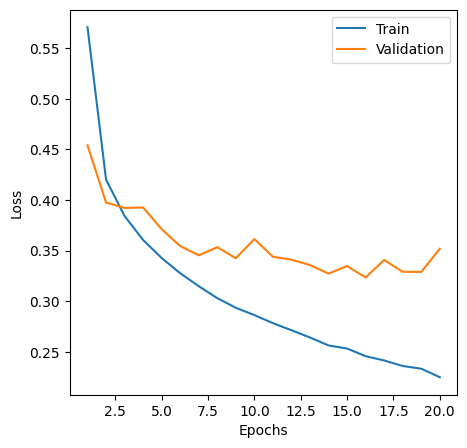

In [71]:
#위에 보면 loss = 0.2249 val_loss: 0.3518 -> 과대적합
#mlp_history 정보를 이용하여 손실함수 그래프를 그려보자 - 과대적합이 나온걸 시각화하자

#history객체는 fit함수가 반환함: 콜백 함수의 일종
#모델 학습의 과정을 기록하기 때문에 에포크별 손실 함수, 보조평가 지표를 불러와 확인할 수 있다.
#그래프: 훈련데이터에 대한 손실함수(loss)와 검증 데이터에 대한 손실함수(val_loss) 통해 그림
#가로축: 에포크
#세로축: 손실 함수 값

def plot_loss_curve(history,total_epoch=10, start=1):
  plt.figure(figsize=(5,5))
  #train
  plt.plot(range(start, total_epoch+1), #x축 길이
           history.history['loss'][start-1:total_epoch],  #y값
           label = 'Train')
  #validation
  plt.plot(range(start, total_epoch+1),
           history.history['val_loss'][start-1:total_epoch],
           label = 'Validation')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
plot_loss_curve(mlp_history, 20,1)

#20포크가 진행되는 동안 훈련 오차는 계속 감소하지만 검증 오차는 0.34 수준에서 횡보하는 추세를 보인다.
#3번째 에포크부터 훈련 오차가 검증 오차보다 낮아지기 시작하여 과대적합이 발생한 것으로 판단할 수 있다.


합성곱 신경망(CNN)

이미지에 합성곱(convolution) 필터를 적용하여 시각적 특징을 추출하는 딥러닝 알고리즘을 말한다.

이미지를 컴퓨터 학습에 사용하려면 숫자 데이터로 변환해야함

보통 이미지 픽셀 값을 0~255 범위의 숫자로 나타내고 RGB색상에 따라 채널을 추가한다.

[세로 픽셀 크기, 가로 픽셀 크기, 채널 크기] 형태를 갖고 3차원 벡터로 표현됨

ex) 단일 색상 1(채널 크기) 컬러 이미지는 3 (3채널을 표현하기 위함)

합성곱 연산은 입력 데이터에 필터를 적용하여 동일한 위치의 원소들끼리 곱한 값을 다시 더한다. --> 크기가 줄어듬

풀링(pooling)

pooling size로 입력 이미지를 겹치지 않게 나누고, 각 구역에서 최대값 또는 평균값을 계산하는 방식으로 이미지의 크기를 줄이는 연산을 말한다.

-max pooling: 최대값을 선택하여 연산

-average pooling: 평균 풀링

In [72]:
#합성곱 신경망 + 풀링을 사용해서 데이터를 학습해보자.
#합성곱 연산을 하는 Conv2D 레이어 뒤에 최대 풀링 연산을 MaxPooling2D 레이어를 연결하자
#합성곱:(Conv2D): 레이어에 16개의 합성곱 필터를 적용하고 커널크기는 3*3으로 하자
#최대 풀링은 2*2 크기

#입력 이미지의 특징을 추출하는 역할을 하는 것이다.

#추출된 피처를 분류기 역할을 하는 완전 연결 신경망에 전달하여 최종 출력(softmax)을 만든다.


#최종적으로 약 17만개의 파라미터를 갖는 합성곱 신경망이 만들어진다.
from tensorflow.keras.layers import Conv2D, MaxPooling2D
cnn_model = Sequential()
cnn_model.add( Conv2D(filters=16, kernel_size=(3,3),
              activation = 'relu', input_shape = [28,28,1] ))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))
cnn_model.add(Flatten())
cnn_model.add(Dense(units=64, activation='relu'))
cnn_model.add(Dense(units=10, activation = 'softmax'))

cnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['acc'])
cnn_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 13, 13, 16)        0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 2704)              0         
                                                                 
 dense_10 (Dense)            (None, 64)                173120    
                                                                 
 dense_11 (Dense)            (None, 10)                650       
                                                                 
Total params: 173930 (679.41 KB)
Trainable params: 173930 (679.41 KB)
Non-trainable params: 0 (0.00 Byte)
______________

In [73]:
cnn_history = cnn_model.fit(X_tr, y_tr, batch_size = 64, epochs=20,
                            validation_data=(X_val,y_val),
                            verbose=2)

Epoch 1/20
750/750 - 20s - loss: 0.5040 - acc: 0.8227 - val_loss: 0.3779 - val_acc: 0.8683 - 20s/epoch - 27ms/step
Epoch 2/20
750/750 - 15s - loss: 0.3453 - acc: 0.8776 - val_loss: 0.3231 - val_acc: 0.8875 - 15s/epoch - 20ms/step
Epoch 3/20
750/750 - 19s - loss: 0.2988 - acc: 0.8924 - val_loss: 0.3065 - val_acc: 0.8923 - 19s/epoch - 25ms/step
Epoch 4/20
750/750 - 15s - loss: 0.2696 - acc: 0.9030 - val_loss: 0.2940 - val_acc: 0.8960 - 15s/epoch - 20ms/step
Epoch 5/20
750/750 - 15s - loss: 0.2473 - acc: 0.9106 - val_loss: 0.2911 - val_acc: 0.8987 - 15s/epoch - 20ms/step
Epoch 6/20
750/750 - 19s - loss: 0.2305 - acc: 0.9159 - val_loss: 0.2775 - val_acc: 0.8992 - 19s/epoch - 25ms/step
Epoch 7/20
750/750 - 22s - loss: 0.2117 - acc: 0.9241 - val_loss: 0.2642 - val_acc: 0.9046 - 22s/epoch - 29ms/step
Epoch 8/20
750/750 - 22s - loss: 0.1959 - acc: 0.9285 - val_loss: 0.2627 - val_acc: 0.9056 - 22s/epoch - 29ms/step
Epoch 9/20
750/750 - 25s - loss: 0.1839 - acc: 0.9335 - val_loss: 0.2586 - val_a

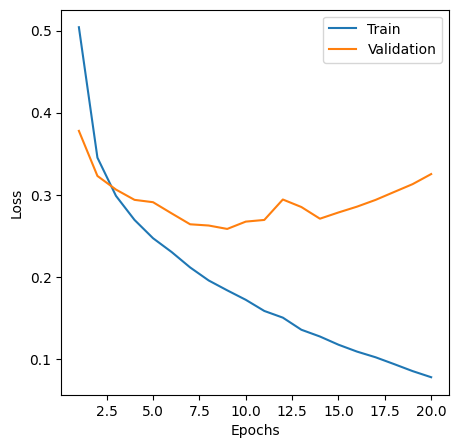

In [74]:
#확실히 MLP 모델보다 정확도가 개선이 되었지만 과대적합 예상됨.
plot_loss_curve(cnn_history,20,1)
#과대적합 확정.. Dropout 필수

In [75]:
#과대적합 방지하자
#드랍아웃을 사용하여 모델 구조를 가볍게 만들면 과대적합을 해소할 수 있다.
#완전 연결 신경망의 Dense 레이어 사이에 드랍아웃 레이어를 추가하자.
from tensorflow.keras.layers import Dropout
def build_cnn():
  model = Sequential()
  model.add(Conv2D(filters=16, kernel_size=(3,3),
                   activation = 'relu', input_shape=[28,28,1]))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Flatten())
  model.add(Dense(units=64, activation = 'relu'))
  model.add(Dropout(rate=0.5))
  model.add(Dense(units=10, activation = 'softmax'))

  model.compile(optimizer='adam',
                loss = 'sparse_categorical_crossentropy',
                metrics=['acc'])
  return model
cnn_model = build_cnn()
cnn_model.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 13, 13, 16)        0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 2704)              0         
                                                                 
 dense_12 (Dense)            (None, 64)                173120    
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 10)                650       
                                                      

In [76]:
#과대 적합을 방지하는 또 다른 방법인 Early Stopping 콜백 함수를 같이 적용하자.
#10에포크 동안 모델 성능이 개선되지 않으면 모델 학습을 멈추고 최종 모델 가중치를 저장

from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience = 10)
cnn_history = cnn_model.fit(X_tr, y_tr, batch_size=64, epochs = 100,
                            validation_data=(X_val, y_val),
                            callbacks=[early_stopping],
                            verbose=0)

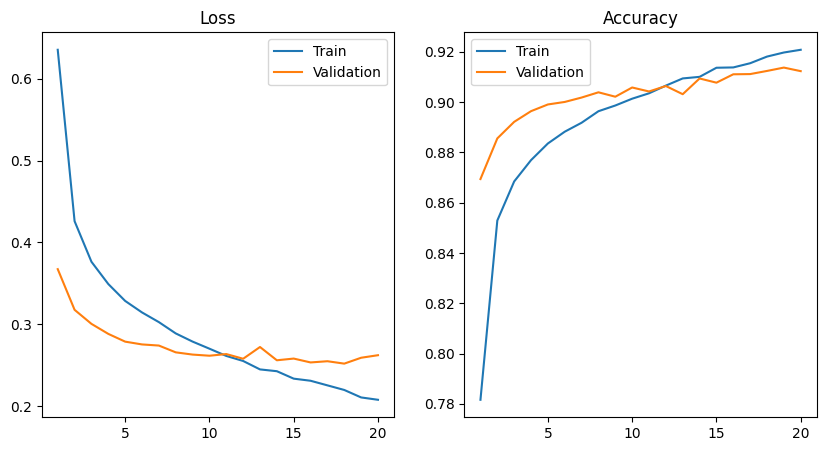

In [77]:
#20 에포크까지 손실함수와 정확도를 시각화해보자
start = 1
end = 20

fig, axes = plt.subplots(1,2,figsize=(10,5))
axes[0].plot(range(start,end+1), cnn_history.history['loss'][start-1:end],
             label='Train')
axes[0].plot(range(start, end+1), cnn_history.history['val_loss'][start-1:end],
             label = 'Validation')
axes[0].set_title('Loss')
axes[0].legend()

axes[1].plot(range(start, end+1),cnn_history.history['acc'][start-1:end],
             label='Train')
axes[1].plot(range(start,end+1),cnn_history.history['val_acc'][start-1:end],
             label = 'Validation')
axes[1].set_title('Accuracy')
axes[1].legend()
plt.show()

In [78]:
cnn_model.evaluate(X_val,y_val)


375/375 [==============================] - 2s 5ms/step - loss: 0.2682 - acc: 0.9128


[0.2681836485862732, 0.9128333330154419]

In [79]:
y_pred_proba=cnn_model.predict(X_test)  #확률값
y_pred_classes = np.argmax(y_pred_proba, axis = -1) #출력한 확률값을 넘파이 argmax함수를 이용하여 분류 클래스로 변환하자
y_pred_classes[:10]

313/313 [==============================] - 2s 7ms/step


array([0, 1, 2, 2, 3, 6, 8, 6, 5, 0])

In [80]:
submission['label'] = y_pred_classes
submission_filepath = drive_path + '/mnist_cnn_submission1.csv'
submission.to_csv(submission_filepath, index=False)   #정확도 0.9175

사용자 정의 콜백함수

검증 정확도 점수가 0.91보다 클 경우 모델 학습을 종료하는 my_callback 함수를 정의하자

on_epoch_end 함수는 매 에포크가 끝날 때마다 실행된다.

함수 안에 if 조건문을 사용하여 검증 정확도가 0.91 보다 크면 model의 stop_training 속성을 true로 변경한다. --> 모델 학습 중단


ModelCheckpoint 콜백 함수를 이용하면 모델을 저장할 수 있다.

monitor 옵션에 설정된 손실함수를 기준으로 모델의 학습 상태를 추적하면서 매 에포크마다 모델을 저장한다. 모델은 HDF5형식으로 저장됨

이때 save_best_only옵션을 true 로 설정하면 모델이 기존 최고치보다 높은 성능을 보일 때만 저장함.

save_weights_only 옵션을 true로 하면 가중치만 저장한다.

In [82]:
from tensorflow.keras.callbacks import Callback

class my_callback(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_acc') > 0.91 ):
      self.model.stop_training = True
      print("\n")
      print("목표 정확도 달성: 검증 정확도 %.4f"%logs.get('val_acc'))

my_callback = my_callback()

#Best Model 저장
from tensorflow.keras.callbacks import ModelCheckpoint

best_model_path = drive_path + "best_cnn_model.h5"
save_best_model = ModelCheckpoint(best_model_path, monitor='val_loss',
                                  save_best_only = True, save_weights_only=False)

#CNN 모델 학습
cnn_model = build_cnn()
cnn_history = cnn_model.fit(X_tr,y_tr,batch_size=64, epochs=100,
                      validation_data = (X_val,y_val),
                      callbacks=[my_callback,save_best_model],
                      verbose=2)


Epoch 1/100
750/750 - 16s - loss: 0.6940 - acc: 0.7587 - val_loss: 0.3969 - val_acc: 0.8599 - 16s/epoch - 22ms/step
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


750/750 - 17s - loss: 0.4693 - acc: 0.8370 - val_loss: 0.3366 - val_acc: 0.8783 - 17s/epoch - 22ms/step
Epoch 3/100
750/750 - 15s - loss: 0.4109 - acc: 0.8558 - val_loss: 0.3177 - val_acc: 0.8866 - 15s/epoch - 20ms/step
Epoch 4/100
750/750 - 15s - loss: 0.3800 - acc: 0.8664 - val_loss: 0.2974 - val_acc: 0.8907 - 15s/epoch - 20ms/step
Epoch 5/100
750/750 - 15s - loss: 0.3590 - acc: 0.8731 - val_loss: 0.2854 - val_acc: 0.8959 - 15s/epoch - 20ms/step
Epoch 6/100
750/750 - 15s - loss: 0.3343 - acc: 0.8813 - val_loss: 0.2839 - val_acc: 0.8953 - 15s/epoch - 20ms/step
Epoch 7/100
750/750 - 15s - loss: 0.3214 - acc: 0.8852 - val_loss: 0.2740 - val_acc: 0.8987 - 15s/epoch - 21ms/step
Epoch 8/100
750/750 - 15s - loss: 0.3095 - acc: 0.8900 - val_loss: 0.2698 - val_acc: 0.9010 - 15s/epoch - 20ms/step
Epoch 9/100
750/750 - 17s - loss: 0.2972 - acc: 0.8929 - val_loss: 0.2625 - val_acc: 0.9037 - 17s/epoch - 22ms/step
Epoch 10/100
750/750 - 16s - loss: 0.2884 - acc: 0.8958 - val_loss: 0.2656 - val_acc

In [83]:
from tensorflow.keras.models import load_model

#ModelCheckPoint에 저장해둔 모델 로딩
best_model = load_model(drive_path + "best_cnn_model.h5")
best_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 13, 13, 16)        0         
 g2D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 2704)              0         
                                                                 
 dense_16 (Dense)            (None, 64)                173120    
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_17 (Dense)            (None, 10)                650       
                                                     

In [84]:
y_pred_proba= best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred_proba, axis=-1)
submission['label'] = y_pred_classes
submission_filepath = drive_path +'mnist_cnn_submission2.csv'
submission.to_csv(submission_filepath, index=False)

313/313 [==============================] - 1s 4ms/step
